<a href="https://colab.research.google.com/github/fell100/Machine-Learning/blob/master/1_regressao_linear_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# Descrição

Neste exercício vamos verificar como podemos usar o PyTorch para implementarmos um dos modelos mais simples: regressão linear.

Nesse modelo, desprezando os valores residuais $\varepsilon$, temos que:

$y_i = \alpha + \beta X_i$

ou, na sua forma matricial:

$Y =B X$

Onde **$Y$** é uma matriz $n$x$1$ observações, **$X$** é uma matriz de tamanho $n$ x $(p+1)$ (sendo a primeira coluna com valores sempre iguais a 1, representando a constante $\alpha$, e $p$ é a quantidade de variáveis explicativas.

Temos mais de uma forma de obtermos os valores de **$B$** para aproximar a função que minimiza os erros. Vamos usar o método conhecido como *Gradient Descent*.

Para dar início, vamos atacar um problema bem simples, tendo apenas uma variável.
Vamos gerar uma série de par de dados ${(x,y)}$ onde 

$y = 3x + 2$

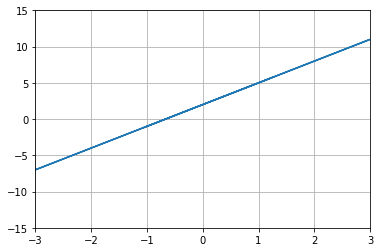

In [2]:
N = 1000
# criar o vetor x com N valores entre -3 e 3
x = (np.random.rand(N)*6)-3
#cria o vetor y
y = 3*x + 2
plt.plot(x,y)
plt.grid('both')
plt.axis([-3,3,-15,15]);

Já temos os nossos dados para ajustar o modelo. Agora, vamos dar início ao uso do Pytorch. Vamos criar uma classe que define o nosso modelo e já cria um método para propogar a entrada e criar uma saída.

A ideia do Pytorch é justamente facilitar o trabalho, e não precisamos nos preocupar com multiplicação de matrizes e, como veremos logo à frente, com operações mais complexas e necessárias, como cálculos de gradientes.

In [3]:
x_treino = np.array(x,dtype=np.float32)
x_treino = x_treino.reshape(-1,1)

y_treino = np.array(y,dtype=np.float32)
y_treino = y_treino.reshape(-1,1)


nEntrada = 1
nSaida = 1
modelo = torch.nn.Linear(nEntrada, nSaida) 

Temos o nosso modelo e dados preprados para treinamento. Agora, vamos nos preparar para usar o potencial das GPUs, caso estejam disponíveis. Caso esteja executando esse código no Google Colaboratory, você pode escolher usar uma GPU no lugar de uma CPU. É sugerido que você use GPUs apenas quando necessário, o que não é o nosso caso aqui.

In [4]:
if torch.cuda.is_available():
  modelo.cuda()
  print('Ueba! Vamos de GPU')
else:
  print('Ok. Vamos de CPU')

Ok. Vamos de CPU


A estrutura acima serve para mover o modelo para a GPU, caso esteja disponível.

O próximo passo é extremamente motivador. A medida de performace do nosso modelo será medida pelo erro quadrático médio. E para otimizar os parâmetros do nosso modelo, queremos usar o *Gradient Descent*.

Os códigos necessários para implementar essas duas operações (cálculo do erro e juste dos parâmetros) não são tão elaborados. Mas o Pytorch já oferece esse suporte.

In [5]:
taxaAprendizagem = 0.01 #posteriormente, altere o valor dessa taxa e verifique o que acontece no treinamento.

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(modelo.parameters(), lr=taxaAprendizagem)      

Recapitulando, temos:

*   Os dados para treinamento
*   O modelo declarado
*   O erro definido (MSE)
*   O algoritmo de ajuste definido (SGD)

Finalmente, podemos treinar o nosso modelo. Como estamos com um caso extremamente simples nas mãos, podemos usar 100 épocas. Veremos que, com deeplearning, 10 épocas pode levar tempo demais.

Para cada época:


*   os gradientes são zerados
*   as saídas do modelo são calculadas
*   os erros são calculados
*   os gradientes são calculados
*   executamos um passo na otimização dos parâmetros




In [6]:
nEpocas = 100
erros=[]

for epoca in range(nEpocas):
    if torch.cuda.is_available():
        entradas = torch.tensor(x_treino).to('cuda')
        saidasEsperadas = torch.tensor(y_treino).to('cuda')
    else:
        entradas = torch.tensor(x_treino) #Variable(torch.from_numpy(x_treino))
        saidasEsperadas = torch.tensor(y_treino) #Variable(torch.from_numpy(y_treino))

    # A linha abaixo zera os gradientes calculados anteriormente, para não acumular informações
    optimizer.zero_grad()

    # calculamos a saída da rede
    saidas = modelo(entradas)

    # calcula o erro
    loss = criterion(saidas, saidasEsperadas)

    # calcular os gradientes
    loss.backward()

    # atualiza parâmetros 
    optimizer.step()

    erros.append(loss.item())

    if(not epoca%10):
      print('Época:' + str(epoca) + ' Erro: ' + str(loss.item()))

Época:0 Erro: 28.27301597595215
Época:10 Erro: 9.1861572265625
Época:20 Erro: 3.30031418800354
Época:30 Erro: 1.3753516674041748
Época:40 Erro: 0.676201343536377
Época:50 Erro: 0.380729079246521
Época:60 Erro: 0.2335316687822342
Época:70 Erro: 0.14988823235034943
Época:80 Erro: 0.09831803292036057
Época:90 Erro: 0.06513408571481705


Observando o gráfico, percebemos que o erro caiu rapidamente logo nas primeras épocas.

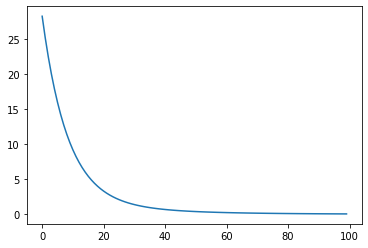

In [7]:
plt.plot(erros)

Podemos verificar o sucesso plotando o gráfico de x versus a saída do modelo para esses valores.


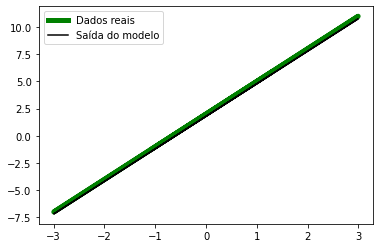

In [8]:
with torch.no_grad():# isso desabilita o cálculo de gradientes
  if torch.cuda.is_available():
    entradas = torch.tensor(x_treino).to('cuda')
  else:
    entradas = torch.tensor(x_treino)
  saidas = modelo(entradas)

plt.clf()
plt.plot(x_treino, y_treino, 'g', label='Dados reais', lw=5)
plt.plot(x_treino, saidas, 'k', label='Saída do modelo')
plt.legend(loc='best')
plt.show()

Como esperado, com um erro muito baixo no treinamento, não existe diferença perceptível entre a saída real e a calculada pelo modelo.

Resta agora verificar como o modelo se sai quando é apresentado para dados desconhecidos. Vamos criar dados entre 10 e 20 e verificar como o modelo se sai.

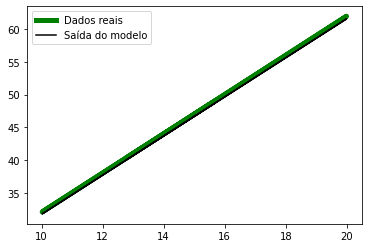

In [9]:
x2 = (np.random.rand(N)*10)+10
#cria o vetor y
y2 = 3*x2 + 2
x_teste = np.array(x2,dtype=np.float32)
x_teste = x_teste.reshape(-1,1)

y_teste = np.array(y2,dtype=np.float32)
y_teste = y_teste.reshape(-1,1)

with torch.no_grad():# isso desabilita o cálculo de gradientes
  if torch.cuda.is_available():
    entradas = torch.tensor(x_teste).to('cuda')
  else:
    entradas = torch.tensor(x_teste)
  saidas = modelo(entradas)


plt.clf()
plt.plot(x_teste, y_teste, 'g', label='Dados reais', lw=5)
plt.plot(x_teste, saidas, 'k', label='Saída do modelo')
plt.legend(loc='best')
plt.show()

## **O que vimos**
Como fazer uma regressão linear usando recursos do PyTorch.

## **Do PyTorch**

torch.nn.Linear()

torch.nn.MSELoss()

torch.optim.SGD()

torch.cuda.is_available()
